<a href="https://colab.research.google.com/github/SomTambe/omniglot-bcs/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/data_background.mat
!wget https://github.com/SomTambe/omniglot-bcs/raw/master/splines.py

--2020-06-16 13:39:34--  https://github.com/SomTambe/omniglot-bcs/raw/master/data_background.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/data_background.mat [following]
--2020-06-16 13:39:35--  https://raw.githubusercontent.com/SomTambe/omniglot-bcs/master/data_background.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21514095 (21M) [application/octet-stream]
Saving to: ‘data_background.mat’

data_background.mat 100%[===================>]  20.52M  30.9MB/s    in 0.7s    

2020-06-16 13:39:37 (30.9 MB/s) - ‘data_background.mat’ saved [21514095/21514095]

--202

In [4]:
import splines
import torch
import glob
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
import scipy
!nvidia-smi

Tue Jun 16 13:39:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
back_dict=splines.mat_to_dict()

In [0]:
spline_prims=splines.spline_dict(back_dict)
images=splines.dict_images()

In [7]:
len(spline_prims) # Since languages are 30, should be equal to 30

30

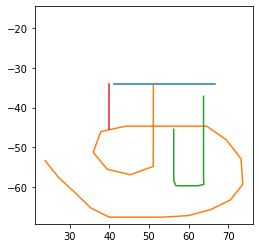

In [8]:
# Let us try to plot a character. Taking an example for a very weird character.
# I found one in the Grantha alphabet. Let us see how its 25-point spline representation looks.

splines.plot_char(spline_prims['Grantha'][1][3][0])
# Note that different colors denote different stokes.

In [0]:
# Our task now remains to train a variational autoencoder on a 2 - unit output for the above.

In [0]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode=nn.Sequential(
            nn.Linear(50,25),
            nn.ReLU(True),
            nn.Linear(25,10),
            nn.ReLU(True),
            nn.Linear(10,4),
        )
        self.mu=nn.Linear(4,2)
        self.var=nn.Linear(4,2)
        
    def forward(self,x):
        x=self.encode(x)
        return [self.mu(x),self.var(x)]

In [0]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decode=nn.Sequential(
            nn.Linear(2,10),
            nn.ReLU(),
            nn.Linear(10,25),
            nn.ReLU(),
            nn.Linear(25,50),
        )
        
    def forward(self,x):
        return self.decode(x)

In [0]:
def gen_latent(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

def loss_function(self,
                      *args,
                      **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

In [0]:
device="cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [0]:
# glob.glob('./**/*.png',recursive=True)
# Will store all filenames of background set images

In [0]:
count=0
for lang in spline_prims :
        # spline_prims[lang][char][inst][0][primitive]
        for i,char in enumerate(spline_prims[lang]) :
            # char = characters of lang
            for j,inst in enumerate(char) :
                # inst = character instance
                for k,primitive in enumerate(inst[0]):
                    count+=1
print('number of total strokes :',count)

number of total strokes : 48762


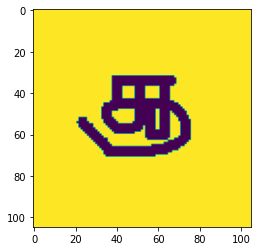

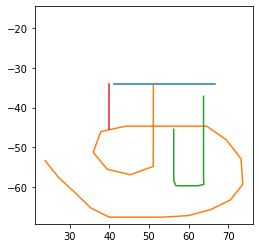

Success !


In [0]:
# images[lang][character][0]['image'][instance][0] -> (105,105) numpy ndarray
# Plotting the same characters, real image vs. the strokes.
img=images['Grantha'][1][0]['image'][3][0]
plt.imshow(img)
plt.show()
splines.plot_char(spline_prims['Grantha'][1][3][0])
print("Success !")

In [0]:
# Now we go on to build the custom dataset class for our data.
# Since our data is not in the form of a direct mapping, what 
# I could have done is that stacked all the data in the form of a matrix. But I wont 
# do that, instead I will use an iterable dataset which is supported by PyTorch dataloader.

In [0]:
from torch.utils.data import IterableDataset, DataLoader
class OmniglotData(IterableDataset):
    """
    Iterable dataset for the 25-spline to 2 vector encoding purpose.
    Expected form to pass data in form of "spline_prims[lang][char][inst][0][primitive]"
    Args:
        data (dict): Data in the same format as used everywhere in our application.
    """
    def __init__(self,data):
        self.data=data
        
    def stream(self):
        # spline_prims[lang][char][inst][0][primitive]
        for lang in self.data:
            for char in self.data[lang]:
                for inst in char:
                    for prim in inst[0]:
                        yield torch.tensor(prim.reshape(-1)).float()
    
    def __iter__(self):
        # print(count)
        return self.stream()

In [0]:
enc=encoder().to(device)
dec=decoder().to(device)

In [0]:
dataset=OmniglotData(spline_prims)
data_loader=DataLoader(dataset,batch_size=5,shuffle=False)

In [0]:
# # Comment out the .reshape(-1) part in the dataset class to test out this portion.
# # Randomly plotting strokes to see whether they are different.
# samp=[]
# for c,dat in enumerate(data_loader):
#     samp.append(dat)
#     if c>5 :
#         break
# for _,c in enumerate(samp):
# #     print(c.squeeze().detach().cpu().numpy().shape)
#     plt.plot(c.squeeze().detach().cpu().numpy()[:,0],c.squeeze().detach().cpu().numpy()[:,1],'')
# plt.axis('square')
# plt.show()
# # Just to make sure there is no problem with loading spline data

In [0]:
criterion=nn.MSELoss()
optimEnc=optim.Adam(enc.parameters(),lr=5e-5)
optimDec=optim.Adam(dec.parameters(),lr=5e-5)

In [0]:
# Yaay, everything is working ! Let us train the encoder now !
import time
num_epochs=100
for epoch in range(num_epochs):
    running_loss=.0
    start=time.time()
    for data in data_loader:
        optimEnc.zero_grad(),optimDec.zero_grad()
        data=data.to(device)
        mid=enc(data)
        out=dec(mid)
        loss=criterion(data,out)
        loss.backward()
        optimEnc.step()
        optimDec.step()
        running_loss+=loss.item()
    print("[%d/%d] Loss : %.4f Time elapsed : %.4f"%(epoch+1,num_epochs,running_loss,time.time()-start))

[1/100] Loss : 2395457.5848 Time elapsed : 44.0117
[2/100] Loss : 999179.2094 Time elapsed : 44.8115
[3/100] Loss : 999117.7772 Time elapsed : 44.4542
[4/100] Loss : 999387.3079 Time elapsed : 44.5297
[5/100] Loss : 999656.1041 Time elapsed : 44.0249
[6/100] Loss : 999917.7825 Time elapsed : 44.6710
[7/100] Loss : 1000170.5548 Time elapsed : 44.8609
[8/100] Loss : 1000414.0581 Time elapsed : 44.9774
[9/100] Loss : 1000648.4516 Time elapsed : 44.8650
[10/100] Loss : 1000874.0431 Time elapsed : 44.5780
[11/100] Loss : 1001091.1450 Time elapsed : 44.8159
[12/100] Loss : 1001300.1088 Time elapsed : 44.4295


KeyboardInterrupt: ignored